In [1]:
from argovisHelpers import helpers as avh
import datetime, pandas, matplotlib
import helpers

API_ROOT='https://argovis-api.colorado.edu/'
API_KEY=''

## small region with oxygen at a given qc? Show time evolution for a subset of pressures

In [2]:
natlantic = [[-51.67968750000001,56.029498073208586],[-41.83593750000001,56.42038489717793],[-32.34375000000001,56.80729573996785],[-19.687500000000004,56.22543989970805],[-15.468750000000002,41.319627582090206],[-27.773437500000004,40.78941637031731],[-42.890625,41.58312932313233],[-52.3828125,41.319627582090206],[-51.67968750000001,56.029498073208586]]
datafilter = {
    'polygon': natlantic,
    'startDate': '2020-01-01T00:00:00Z',
    'endDate': '2021-01-01T00:00:00Z',
    'data': 'doxy,1',
    'presRange': [0,1000]
}

floats = avh.query('argo', options=datafilter, apikey=API_KEY, apiroot=API_ROOT)

In [3]:
float_longitudes = [x['geolocation']['coordinates'][0] for x in floats]
float_latitudes  = [x['geolocation']['coordinates'][1] for x in floats]
float_id = [x['_id'].split('_')[0] for x in floats]

## choose markers on map categorically by float ID
id_markermap = helpers.marker_map(set(float_id))
id_markers = [id_markermap[x] for x in float_id]

/usr/local/envs/argovis_demos/lib/python3.9/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/local/envs/argovis_demos/lib/python3.9/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/local/envs/argovis_demos/lib/python3.9/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


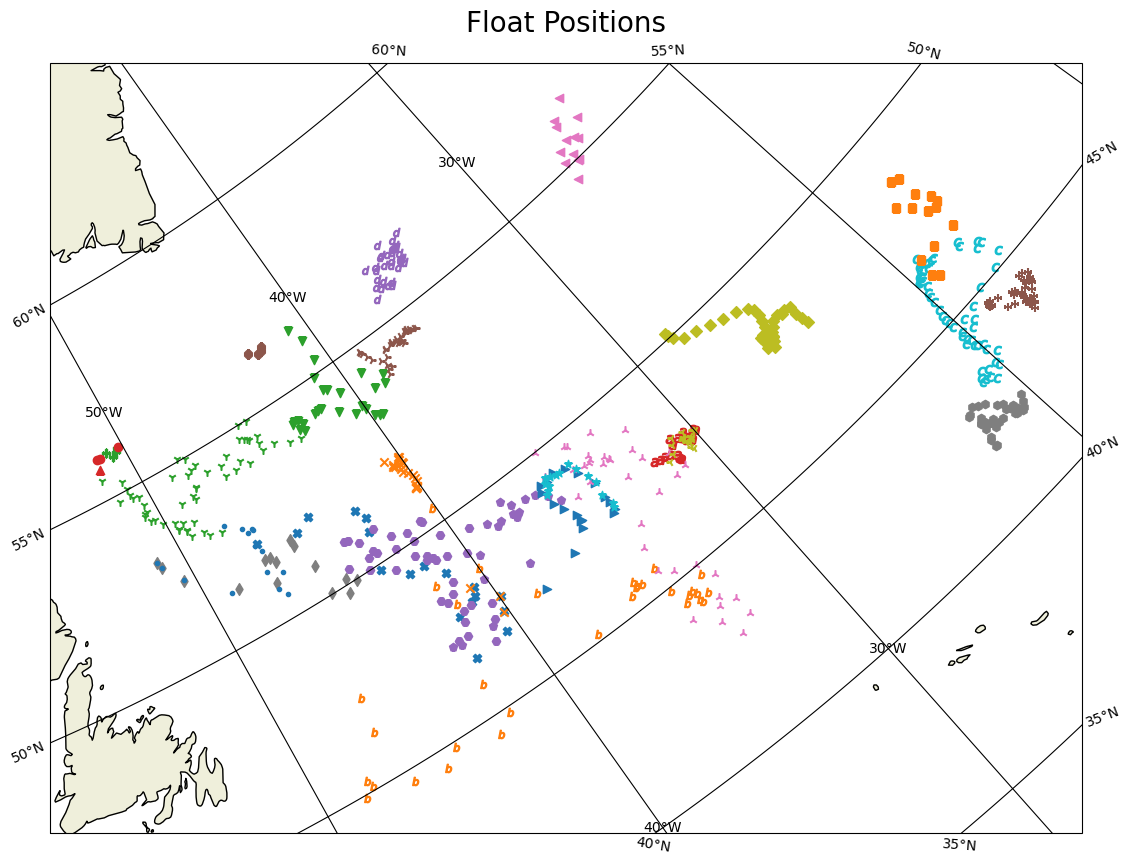

In [4]:
helpers.simple_map(float_longitudes,float_latitudes,markers=id_markers, title='Float Positions')

In [5]:
df = helpers.level_df(floats, ['pressure', 'doxy', 'months'])

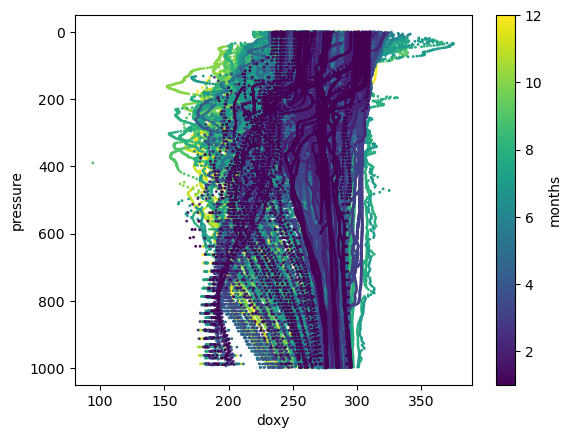

In [6]:
plot = df.plot(kind='scatter', x='doxy', y='pressure', c='months', colormap='viridis', s=1);
plot.invert_yaxis()

## global map of all oxygen profiles
 - could add a thin pressure filter to this to satisfy the request "Map with oxygen measurements for a month and within a thin pressure layer" - but do we need both, the difference seems trivial?

In [7]:
datafilter = {
    'startDate': '2020-01-01T00:00:00Z',
    'endDate': '2021-01-01T00:00:00Z',
    'data': 'doxy',
    'compression': 'minimal'
}

doxy = avh.query('argo', options=datafilter, apikey=API_KEY, apiroot=API_ROOT)

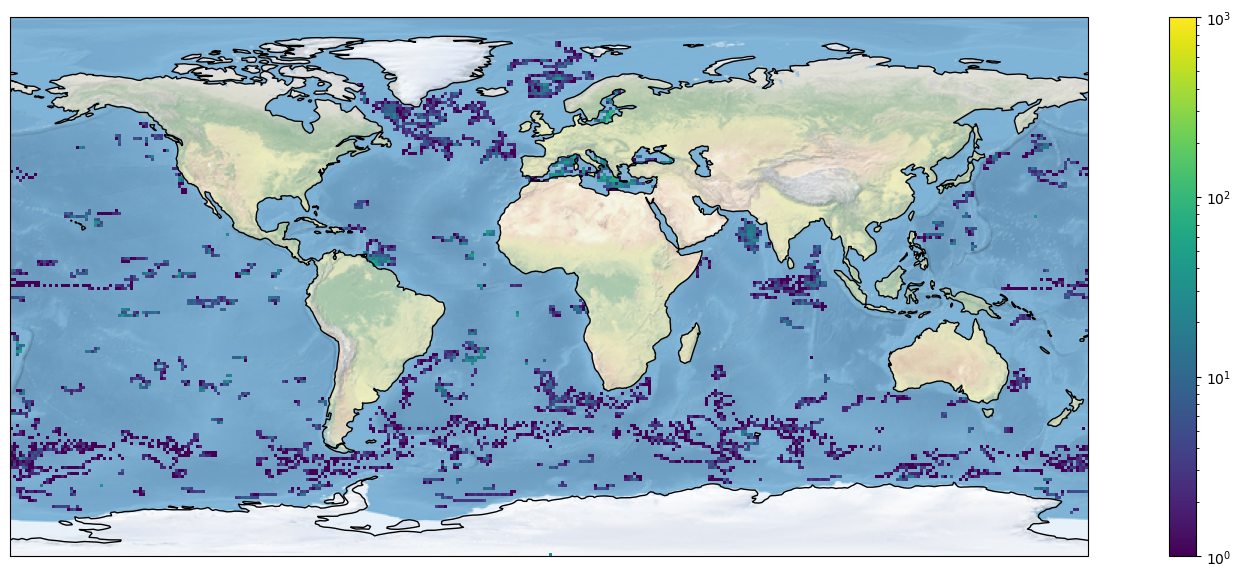

In [8]:
df = helpers.mapping_df(doxy)
helpers.map_count_in_bins(df,datafilter['startDate'],datafilter['endDate'])

## Timeseries for the number of oxygen profiles globally

<AxesSubplot:xlabel='timestamps,timestamps'>

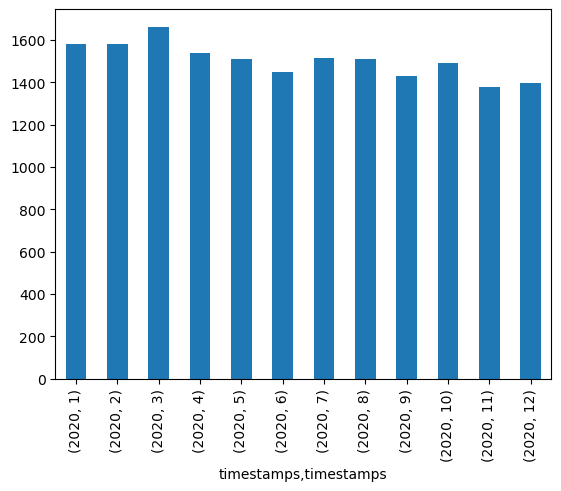

In [12]:
df['timestamps'].groupby([df["timestamps"].dt.year, df["timestamps"].dt.month]).count().plot(kind="bar")